# Week 6 – Decision Trees and Random Forest

This notebook focuses on concepts such as trees and random forests.

In [335]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

In [336]:
df = pd.read_csv('Hospital_Inpatient_Discharge_2.csv')

/tmp/ipykernel_6506/3893216988.py:1: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Hospital_Inpatient_Discharge_2.csv')


In [337]:
df.head()

,Hospital Service Area,Hospital County,Operating Certificate Number,Permanent Facility Id,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,...,APR Severity of Illness Description,APR Risk of Mortality,APR Medical Surgical Description,Payment Typology 1,Payment Typology 2,Payment Typology 3,Birth Weight,Emergency Department Indicator,Total Charges,Total Costs
0,New York City,Bronx,7000006.0,1169.0,Montefiore Medical Center - Henry & Lucy Moses...,70 or Older,104,M,Other Race,Spanish/Hispanic,...,Major,Extreme,Medical,Medicare,Medicaid,NaN,NaN,Y,320922.43,60241.34
1,New York City,Bronx,7000006.0,1169.0,Montefiore Medical Center - Henry & Lucy Moses...,50 to 69,104,F,White,Not Span/Hispanic,...,Moderate,Minor,Medical,Private Health Insurance,NaN,NaN,NaN,Y,61665.22,9180.69
2,New York City,Bronx,7000006.0,1168.0,Montefiore Medical Center-Wakefield Hospital,18 to 29,104,F,Other Race,Spanish/Hispanic,...,Minor,Minor,Surgical,Medicaid,NaN,NaN,NaN,N,42705.34,11366.50
3,New York City,Bronx,7000006.0,3058.0,Montefiore Med Center - Jack D Weiler Hosp of ...,70 or Older,104,M,Other Race,Spanish/Hispanic,...,Major,Major,Medical,Medicare,Medicaid,NaN,NaN,Y,72700.17,12111.75
4,New York City,Bronx,7000006.0,1169.0,Montefiore Medical Center - Henry & Lucy Moses...,50 to 69,104,F,Black/African American,Not Span/Hispanic,...,Moderate,Minor,Medical,Medicare,Medicaid,NaN,NaN,Y,55562.51,8339.72


Get rid of unnecessary columns.

In [338]:
df_cleaned = df.drop(columns=['Hospital Service Area','Hospital County', 'Operating Certificate Number', 'Permanent Facility Id', 'Facility Name', 'Zip Code - 3 digits', 'CCSR Diagnosis Code', 'CCSR Procedure Code', 'APR DRG Code', 'APR MDC Code', 'APR Severity of Illness Code', 'Birth Weight', 'Discharge Year', 'Total Charges', 'Total Costs'])

Replace +120 with just 120 for the target variable and make sure it is numeric.

In [339]:
df_cleaned['Length of Stay'] = df_cleaned['Length of Stay'].replace('120 +', 120)
df_cleaned['Length of Stay'] = pd.to_numeric(df_cleaned['Length of Stay'], errors='coerce')
df_cleaned = df_cleaned.dropna(subset=['Length of Stay'])

Define X and Y

In [340]:
X = df_cleaned.drop(columns='Length of Stay')
y = df_cleaned['Length of Stay']

Split trainn encode categorical features and apply model

In [341]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [342]:
X_train.select_dtypes(include='object').nunique()
X_train_encoded = pd.get_dummies(X_train)
X_test_encoded = pd.get_dummies(X_test)
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

In [343]:
from sklearn.tree import DecisionTreeRegressor
tree_model = DecisionTreeRegressor(random_state=42)


In [344]:
tree_model.fit(X_train_encoded, y_train)

DecisionTreeRegressor(random_state=42)

In [345]:
y_pred = tree_model.predict(X_test_encoded)

In [346]:
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred))
r2_dt = r2_score(y_test, y_pred)

print("Random Forest RMSE:", rmse_dt)
print("Random Forest R²:", r2_dt)

Random Forest RMSE: 8.885430786412293
Random Forest R²: -0.054702478690866974


The model probably didn’t perform well for a few reasons. First, the target we’re trying to predict—Length of Stay—might be too uneven or skewed, especially if it had extreme values like “120+”. Even after cleaning, that kind of spread can mess with regression. Second, the features we used might not actually tell us much about how long someone stays. And lastly, if we turned a bunch of categories into dummy variables, we may have ended up with way too many columns, which can overwhelm the model and make it harder for it to generalize.

# Now Random Forest

In [347]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [348]:
X_train.select_dtypes(include='object').nunique()
X_train_encoded = pd.get_dummies(X_train)
X_test_encoded = pd.get_dummies(X_test)
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

I will apply a Log transformation to the target variable to try to stabalize it.

In [349]:
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

In [350]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_encoded, y_train_log)

RandomForestRegressor(random_state=42)

In [351]:
y_pred_log = rf_model.predict(X_test_encoded)
y_pred = np.expm1(y_pred_log)

In [352]:
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred))
r2_rf = r2_score(y_test, y_pred)

print("Log-Adjusted Random Forest RMSE:", rmse_rf)
print("Log-Adjusted Random Forest R²:", r2_rf)

Log-Adjusted Random Forest RMSE: 7.06406448040522
Log-Adjusted Random Forest R²: 0.3333739208343762


This time the results are way better than the Decision Tree model. The log transformation helped a lot. Maybe a tunning hyperparameters would make the model work even better.

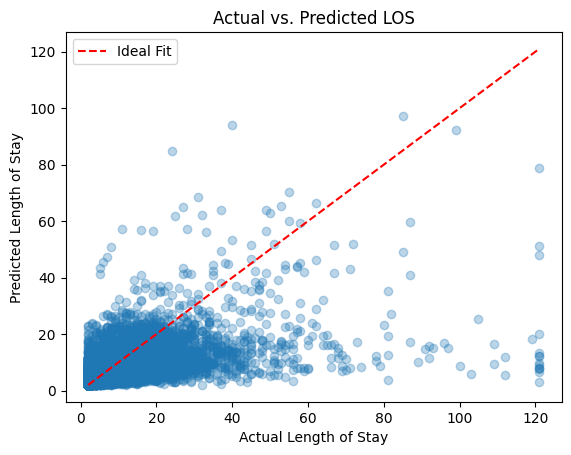

In [353]:
import matplotlib.pyplot as plt

y_test_actual = np.exp(y_test_log)
y_pred_actual = np.exp(y_pred_log)

plt.scatter(y_test_actual, y_pred_actual, alpha=0.3)
plt.plot([y_test_actual.min(), y_test_actual.max()],
         [y_test_actual.min(), y_test_actual.max()],
         'r--', label='Ideal Fit')
plt.xlabel("Actual Length of Stay")
plt.ylabel("Predicted Length of Stay")
plt.title("Actual vs. Predicted LOS")
plt.legend()
plt.show()

Most of the points are clustered in the bottom left part of the graph, which means the model performs better for shorter days of stay.